# Gated CNN for IMDB Sentiment Classification
## Training, Evaluation and Nature-style Analysis

This notebook provides a full, publication-grade pipeline for training and evaluating a Gated CNN model on the IMDB sentiment dataset.

In [25]:
import os
import random
import numpy as np
import torch
import matplotlib.pyplot as plt

from data.imdb_dataset import IMDBDataset, Vocab, get_dataloader
# from SEmodels.gcnn import GCNN
from SEmodels.gcnn_advance import GCNN
from SEutils.trainer import train_one_epoch, evaluate
from SEutils.SEmetrics import compute_roc_pr, expected_calibration_error

plt.rcParams['figure.dpi'] = 120



In [26]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

IMDB_ROOT = './data/aclImdb'
BATCH_SIZE = 256
EPOCHS = 30
LR = 1e-3
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

assert os.path.isdir(IMDB_ROOT), f'Invalid path: {IMDB_ROOT}'
print('Using device:', DEVICE)

Using device: cuda


In [27]:
train_dataset = IMDBDataset(IMDB_ROOT, split='train')
train_texts = [text for _, text in train_dataset.samples]

vocab = Vocab(min_freq=20)
vocab.build(train_texts)

print('Vocabulary size:', len(vocab))

Vocabulary size: 13606


In [28]:
train_loader = get_dataloader(IMDB_ROOT, 'train', BATCH_SIZE, vocab, shuffle=True)
test_loader = get_dataloader(IMDB_ROOT, 'test', BATCH_SIZE, vocab, shuffle=False)

In [29]:
model = GCNN(vocab_size=len(vocab), embedding_dim=64, num_classes=2).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

print('Total parameters:', sum(p.numel() for p in model.parameters()))

Total parameters: 953090


In [30]:
history = {'loss': [], 'accuracy': [], 'precision': [], 'recall': [], 'f1': []}

for epoch in range(EPOCHS):
    train_loss = train_one_epoch(model, train_loader, optimizer, DEVICE)
    metrics = evaluate(model, test_loader, DEVICE)

    history['loss'].append(train_loss)
    history['accuracy'].append(metrics['accuracy'])
    history['precision'].append(metrics['precision'])
    history['recall'].append(metrics['recall'])
    history['f1'].append(metrics['f1'])

    print(f"Epoch {epoch:02d} | Loss {train_loss:.4f} | Acc {metrics['accuracy']:.4f} | F1 {metrics['f1']:.4f}")

Epoch 00 | Loss 0.6262 | Acc 0.7410 | F1 0.7388
Epoch 01 | Loss 0.4864 | Acc 0.8067 | F1 0.8010
Epoch 02 | Loss 0.4016 | Acc 0.8343 | F1 0.8280
Epoch 03 | Loss 0.3477 | Acc 0.8478 | F1 0.8510
Epoch 04 | Loss 0.3097 | Acc 0.8601 | F1 0.8567
Epoch 05 | Loss 0.2829 | Acc 0.8589 | F1 0.8497
Epoch 06 | Loss 0.2594 | Acc 0.8699 | F1 0.8645
Epoch 07 | Loss 0.2355 | Acc 0.8760 | F1 0.8766
Epoch 08 | Loss 0.2185 | Acc 0.8760 | F1 0.8739
Epoch 09 | Loss 0.2012 | Acc 0.8770 | F1 0.8732
Epoch 10 | Loss 0.1902 | Acc 0.8711 | F1 0.8631
Epoch 11 | Loss 0.1771 | Acc 0.8806 | F1 0.8791
Epoch 12 | Loss 0.1639 | Acc 0.8816 | F1 0.8791
Epoch 13 | Loss 0.1530 | Acc 0.8797 | F1 0.8822
Epoch 14 | Loss 0.1413 | Acc 0.8808 | F1 0.8823
Epoch 15 | Loss 0.1365 | Acc 0.8819 | F1 0.8829
Epoch 16 | Loss 0.1333 | Acc 0.8823 | F1 0.8817
Epoch 17 | Loss 0.1208 | Acc 0.8822 | F1 0.8821
Epoch 18 | Loss 0.1098 | Acc 0.8794 | F1 0.8828
Epoch 19 | Loss 0.1035 | Acc 0.8806 | F1 0.8832
Epoch 20 | Loss 0.0966 | Acc 0.8788 | F1

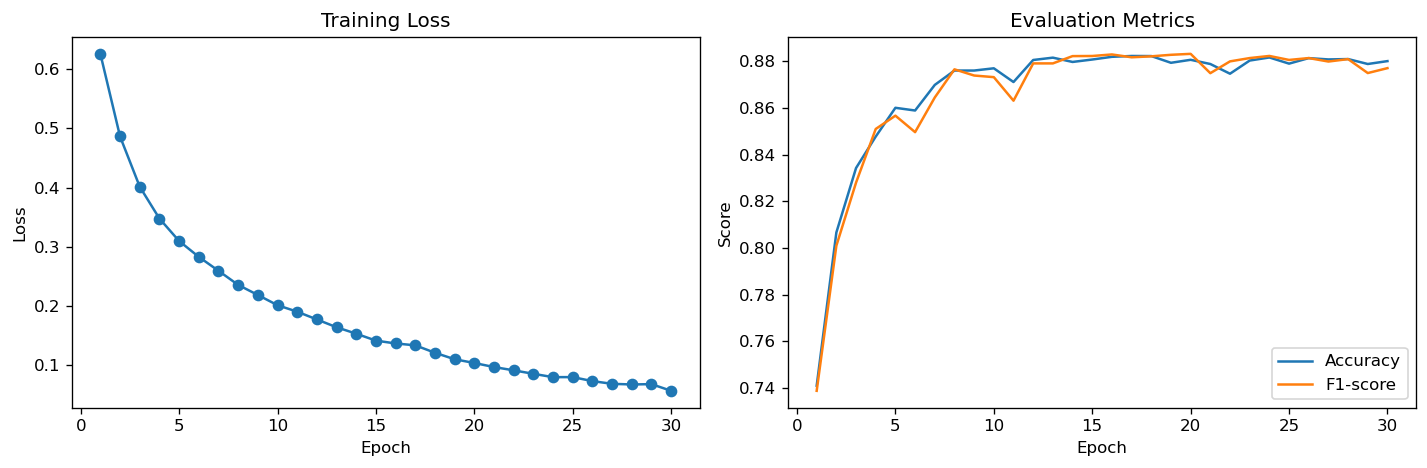

In [31]:
epochs = np.arange(1, EPOCHS + 1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, history['loss'], marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs, history['accuracy'], label='Accuracy')
plt.plot(epochs, history['f1'], label='F1-score')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title('Evaluation Metrics')
plt.legend()
plt.tight_layout()
plt.show()

In [32]:
model.eval()

all_labels = []
all_preds = []
all_probs = []

with torch.no_grad():
    for labels, inputs in test_loader:
        labels = labels.to(DEVICE)
        inputs = inputs.to(DEVICE)

        logits = model(inputs)
        probs = torch.softmax(logits, dim=-1)[:, 1]
        preds = logits.argmax(dim=-1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

all_labels = np.array(all_labels)
all_preds = np.array(all_preds)
all_probs = np.array(all_probs)


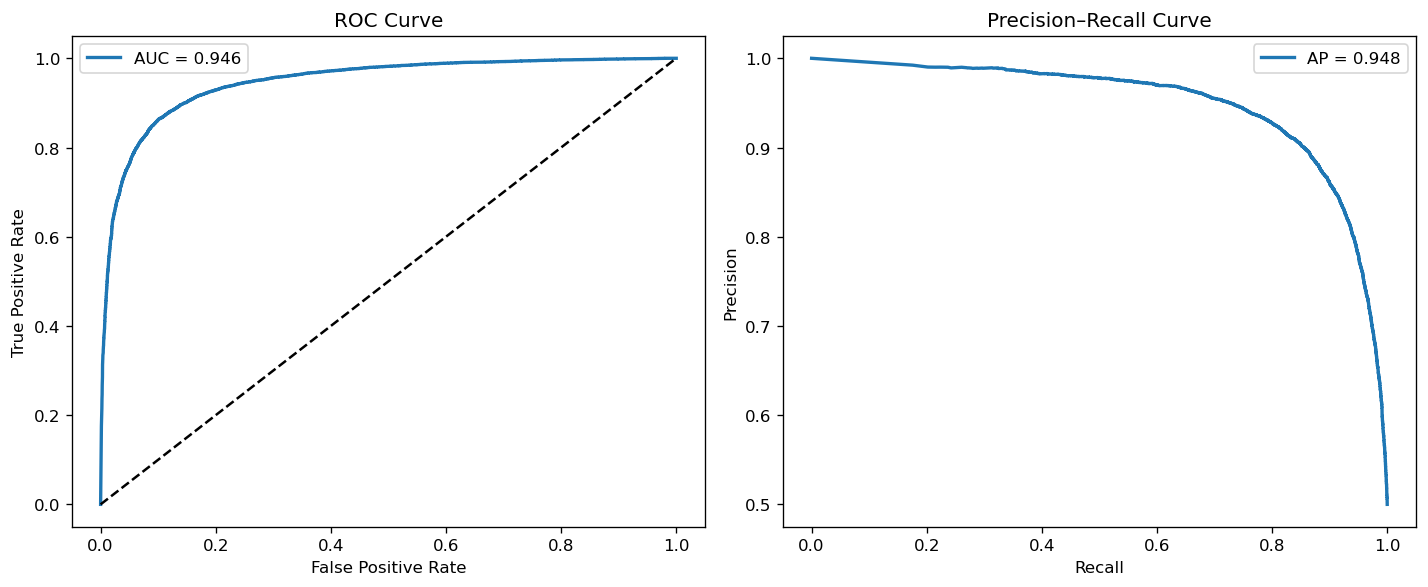

In [33]:
rocpr = compute_roc_pr(all_labels, all_probs)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(rocpr["fpr"], rocpr["tpr"], lw=2,
         label=f"AUC = {rocpr['roc_auc']:.3f}")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(rocpr["recall"], rocpr["precision"], lw=2,
         label=f"AP = {rocpr['ap']:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# def plot_reliability(y_true, y_prob, n_bins=10):
#     bins = np.linspace(0, 1, n_bins + 1)
#     bin_ids = np.digitize(y_prob, bins) - 1

#     accs, confs = [], []
#     for i in range(n_bins):
#         mask = bin_ids == i
#         if mask.sum() == 0:
#             continue
#         accs.append((y_true[mask] == (y_prob[mask] > 0.5)).mean())
#         confs.append(y_prob[mask].mean())

#     plt.figure(figsize=(5, 5))
#     plt.plot(confs, accs, marker="o")
#     plt.plot([0, 1], [0, 1], "k--")
#     plt.xlabel("Confidence")
#     plt.ylabel("Accuracy")
#     plt.title("Reliability Diagram")
#     plt.show()


# ece = expected_calibration_error(all_labels, all_probs)
# print(f"Expected Calibration Error (ECE): {ece:.4f}")

# plot_reliability(all_labels, all_probs)


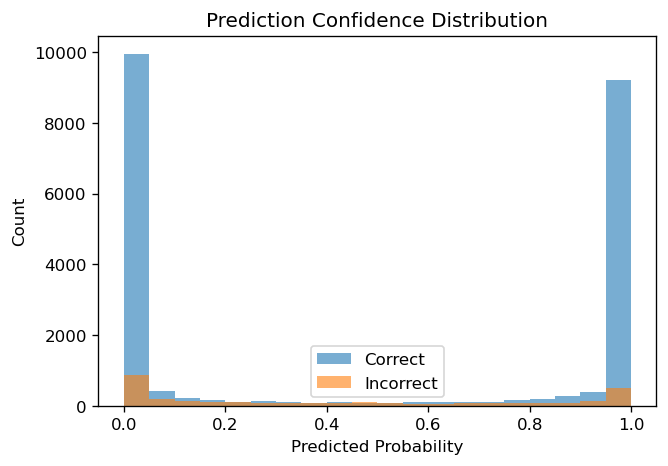

In [35]:
correct = all_preds == all_labels

plt.figure(figsize=(6, 4))
plt.hist(all_probs[correct], bins=20, alpha=0.6, label="Correct")
plt.hist(all_probs[~correct], bins=20, alpha=0.6, label="Incorrect")
plt.xlabel("Predicted Probability")
plt.ylabel("Count")
plt.title("Prediction Confidence Distribution")
plt.legend()
plt.show()


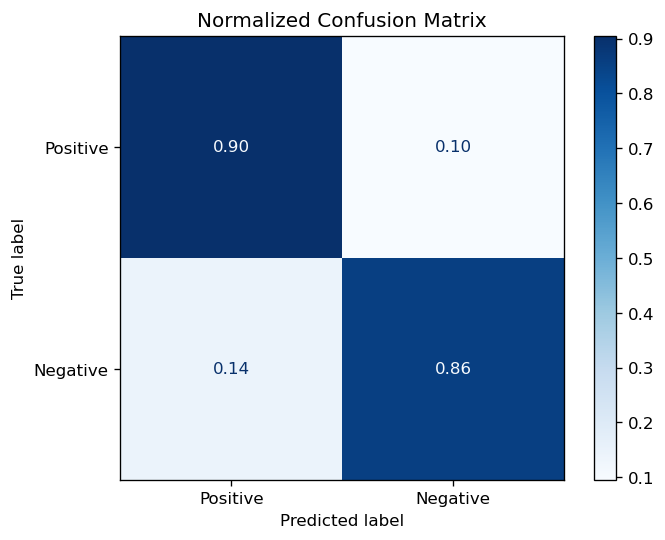

In [36]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

cm = confusion_matrix(all_labels, all_preds, normalize="true")

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Positive", "Negative"],
)
disp.plot(cmap="Blues", values_format=".2f")
plt.title("Normalized Confusion Matrix")
plt.show()
